PROJECT EXPLANATION

1) CAMERA CALIBRATION

In [ ]:
# Import required modules 
import cv2 
import numpy as np 
import os 
import glob 


# Define the dimensions of checkerboard 
CHECKERBOARD = (6, 9) 


# stop the iteration when specified 
# accuracy, epsilon, is reached or 
# specified number of iterations are completed. 
criteria = (cv2.TERM_CRITERIA_EPS +
			cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001) 


# Vector for 3D points 
threedpoints = [] 

# Vector for 2D points 
twodpoints = [] 


# 3D points real world coordinates 
objectp3d = np.zeros((1, CHECKERBOARD[0] 
					* CHECKERBOARD[1], 
					3), np.float32) 
objectp3d[0, :, :2] = np.mgrid[0:CHECKERBOARD[0], 
							0:CHECKERBOARD[1]].T.reshape(-1, 2) 
prev_img_shape = None


# Extracting path of individual image stored 
# in a given directory. Since no path is 
# specified, it will take current directory 
# jpg files alone 
#images = glob.glob('./images/*.jpg')
#images = glob.glob('cc1.jpg') 

images = ['cc1.jpg','cc2.jpg','cc3.jpg','cc4.jpg','cc5.jpg']


for filename in images: 
	image = cv2.imread(filename) 
	grayColor = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 

	# Find the chess board corners 
	# If desired number of corners are 
	# found in the image then ret = true 
	ret, corners = cv2.findChessboardCorners( 
					grayColor, CHECKERBOARD, 
					cv2.CALIB_CB_ADAPTIVE_THRESH 
					+ cv2.CALIB_CB_FAST_CHECK +
					cv2.CALIB_CB_NORMALIZE_IMAGE) 

	# If desired number of corners can be detected then, 
	# refine the pixel coordinates and display 
	# them on the images of checker board 
	if ret == True: 
		threedpoints.append(objectp3d) 

		# Refining pixel coordinates 
		# for given 2d points. 
		corners2 = cv2.cornerSubPix( 
			grayColor, corners, (11, 11), (-1, -1), criteria) 

		twodpoints.append(corners2) 

		# Draw and display the corners 
		image = cv2.drawChessboardCorners(image, 
										CHECKERBOARD, 
										corners2, ret) 

	cv2.imshow('img', image) 
	cv2.waitKey(0) 

cv2.destroyAllWindows() 

h, w = image.shape[:2] 


# Perform camera calibration by 
# passing the value of above found out 3D points (threedpoints) 
# and its corresponding pixel coordinates of the 
# detected corners (twodpoints) 
ret, matrix, distortion, r_vecs, t_vecs = cv2.calibrateCamera( 
	threedpoints, twodpoints, grayColor.shape[::-1], None, None) 


# Displaying required output 
print(" Camera matrix:") 
print(matrix) 

print("\n Distortion coefficient:") 
print(distortion) 

print("\n Rotation Vectors:") 
print(r_vecs) 

print("\n Translation Vectors:") 
print(t_vecs) 

# Save the camera calibration result
calibration_file = "camera_calibration.npz"

# Saving the calibration results to a file
np.savez(calibration_file, camera_matrix=matrix, distortion_coefficient=distortion, rotation_vectors=r_vecs, translation_vectors=t_vecs)

print(f"\nCalibration data saved to {calibration_file}")

APRIL TAG DETECTION, DISTANCE MEASUREMENT AND DIRECTION/POSITION/ORIENTATION

In [ ]:
import cv2
import numpy as np
from pupil_apriltags import Detector


# Start webcam capture
cap = cv2.VideoCapture(0)

ret, frame = cap.read()
if ret:
    frame_height, frame_width = frame.shape[:2]
    frame_center_x = frame_width // 2
    frame_center_y = frame_height // 2
else:
    print("Failed to capture video frame. Exiting...")
    cap.release()
    exit(1)

cap.release()

# Load camera calibration parameters
data = np.load('camera_calibration.npz')
camera_matrix = data['camera_matrix']
distortion_coefficient = data['distortion_coefficient']

# Initialize AprilTag detector
at_detector = Detector(families='tag36h11',
                       nthreads=4,
                       quad_decimate=1.0,
                       quad_sigma=0.0,
                       refine_edges=1,
                       decode_sharpening=0.25,
                       debug=0)

# Start webcam capture
cap = cv2.VideoCapture(0)




while True:
    # Capture frame-by-frame
    ret, frame = cap.read()
    if not ret:
        break

    # Convert frame to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect AprilTags in the image
    tags = at_detector.detect(gray, estimate_tag_pose=True, camera_params=[camera_matrix[0,0], camera_matrix[1,1], camera_matrix[0,2], camera_matrix[1,2]], tag_size=0.165) # tag_size should be set to the real size of the tag in meters

    for tag in tags:
        # Draw a bounding box around the detected tag
        cv2.polylines(frame, [np.array(tag.corners, dtype=np.int32).reshape((-1,1,2))], True, (0,255,0), 2)

        # Display the tag ID on the image
        cv2.putText(frame, str(tag.tag_id), (int(tag.center[0]), int(tag.center[1])), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        # Calculate distance from the camera (assuming tvec is in meters)
        distance = np.linalg.norm(tag.pose_t)
        print(f"Distance to tag {tag.tag_id}: {distance} meters")

        # `tag.center[0]` which is the x-coordinate of the center of the tag in the camera frame
        # And `frame_center_x` which is the x-coordinate of the center of the camera frame

        turn_threshold = 50  # How many pixels from the center to consider as a turn
        turning = False

        if distance > 2:
           if abs(tag.center[0] - frame_center_x) > turn_threshold:
              turning = True
              if tag.center[0] > frame_center_x:
                   # The tag (and therefore the person) has moved to the right of the center
                   print(f'TURN RIGHT\n')
              else:
                  # The tag (and therefore the person) has moved to the left of the center
                  print(f'TURN LEFT\n')
           else:
            # The tag is approximately centered, move straight
                 print(f'MOVE FORWARD\n')
        else:
           print(f'STOP\n')

    # Display the resulting frame
    cv2.imshow('Frame', frame)

    # Break the loop with 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()






SEND DATA TO ARDUINO:
you will need to add below code to above april tag code:
do not run the below code by itself , it will output multiple errors 

In [ ]:
import serial
import time


# Define the serial port and baud rate
ser = serial.Serial('COM4', 9600)  # Replace 'COMX' with your Arduino's COM port

# Delay to allow time for the serial connection to be established
time.sleep(2)

if distance > 3:
           if abs(tag.center[0] - frame_center_x) > turn_threshold:
              turning = True
              if tag.center[0] > frame_center_x:
                # The tag (and therefore the person) has moved to the right of the center
                print(f'TURN RIGHT\n')
                speed = 30  
                slow = 15
                speed_string = f"{speed},{slow}\n"
                ser.write(speed_string.encode())
                time.sleep(1)
              else:
                # The tag (and therefore the person) has moved to the left of the center
                print(f'TURN LEFT\n')
                speed = 15  
                slow = 30
                speed_string = f"{speed},{slow}\n"
                ser.write(speed_string.encode())
                time.sleep(1)
           else:
            # The tag is approximately centered, move straight
            print(f'MOVE FORWARD\n')
            speed = 30  
            slow = 30
            speed_string = f"{speed},{slow}\n"
            ser.write(speed_string.encode())
            time.sleep(1)
else:
         #stop
         print(f'STOP\n')
         speed = 0
         slow = 0
         speed_string = f"{speed},{slow}\n"
         ser.write(speed_string.encode())
         time.sleep(1)

THE ADDED CODE WOULD LOOK LIKE THIS:
do not run the below code untill you read the arduino ide code much below


In [ ]:
import cv2
import numpy as np
from pupil_apriltags import Detector
import serial
import time


# Define the serial port and baud rate
ser = serial.Serial('COM4', 9600)  # Replace 'COMX' with your Arduino's COM port

# Delay to allow time for the serial connection to be established
time.sleep(2)

# Start webcam capture
cap = cv2.VideoCapture(0)

ret, frame = cap.read()
if ret:
    frame_height, frame_width = frame.shape[:2]
    frame_center_x = frame_width // 2
    frame_center_y = frame_height // 2
else:
    print("Failed to capture video frame. Exiting...")
    cap.release()
    exit(1)

cap.release()


# Load camera calibration parameters
data = np.load('camera_calibration.npz')
camera_matrix = data['camera_matrix']
distortion_coefficient = data['distortion_coefficient']

# Initialize AprilTag detector
at_detector = Detector(families='tag36h11',
                       nthreads=4,
                       quad_decimate=1.0,
                       quad_sigma=0.0,
                       refine_edges=1,
                       decode_sharpening=0.25,
                       debug=0)

# Start webcam capture
cap = cv2.VideoCapture(0)

while True:
    # Capture frame-by-frame
    ret, frame = cap.read()
    if not ret:
        break

    # Convert frame to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect AprilTags in the image
    tags = at_detector.detect(gray, estimate_tag_pose=True, camera_params=[camera_matrix[0,0], camera_matrix[1,1], camera_matrix[0,2], camera_matrix[1,2]], tag_size=0.165) # tag_size should be set to the real size of the tag in meters

    for tag in tags:
        # Draw a bounding box around the detected tag
        cv2.polylines(frame, [np.array(tag.corners, dtype=np.int32).reshape((-1,1,2))], True, (0,255,0), 2)

        # Display the tag ID on the image
        cv2.putText(frame, str(tag.tag_id), (int(tag.center[0]), int(tag.center[1])), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        # Calculate distance from the camera (assuming tvec is in meters)
        distance = np.linalg.norm(tag.pose_t)
        print(f"Distance to tag {tag.tag_id}: {distance} meters")

        turn_threshold = 50  # How many pixels from the center to consider as a turn
        turning = False

        if distance > 3:
           if abs(tag.center[0] - frame_center_x) > turn_threshold:
              turning = True
              if tag.center[0] > frame_center_x:
                # The tag (and therefore the person) has moved to the right of the center
                print(f'TURN RIGHT\n')
                speed = 30  
                slow = 15
                speed_string = f"{speed},{slow}\n"
                ser.write(speed_string.encode())
                time.sleep(1)
              else:
                # The tag (and therefore the person) has moved to the left of the center
                print(f'TURN LEFT\n')
                speed = 15  
                slow = 30
                speed_string = f"{speed},{slow}\n"
                ser.write(speed_string.encode())
                time.sleep(1)
           else:
            # The tag is approximately centered, move straight
            print(f'MOVE FORWARD\n')
            speed = 30  
            slow = 30
            speed_string = f"{speed},{slow}\n"
            ser.write(speed_string.encode())
            time.sleep(1)
        else:
         #stop
         print(f'STOP\n')
         speed = 0
         slow = 0
         speed_string = f"{speed},{slow}\n"
         ser.write(speed_string.encode())
         time.sleep(1)



    # Display the resulting frame
    cv2.imshow('Frame', frame)

    # Break the loop with 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()


ARDUINO IDE CODE:
THE BELOW CODE WOULD RUN IN ARDUINO IDE

In [ ]:
// Define motor control pins
const int motor1PWM = 5;  // PWM control for motor 1
const int motor2PWM = 10;  // PWM control for motor 2
const int PIN_DIR = 2;    // Motor direction signal



void setup() {
  // Set motor control pins as outputs
  pinMode(motor1PWM, OUTPUT);
  pinMode(motor2PWM, OUTPUT);
  pinMode(PIN_DIR, OUTPUT);
  Serial.begin(9600);  // Initialize serial communication
  


}

void loop() {
  if (Serial.available() > 0) {
    String speedString = Serial.readStringUntil('\n');  // Read the string until newline
    int commaIndex = speedString.indexOf(',');  // Find the position of the comma
    int speed = speedString.substring(0, commaIndex).toInt(); // Parse first speed value
    int slow = speedString.substring(commaIndex + 1).toInt(); // Parse second speed value

    analogWrite(motor1PWM, slow);  // Set motor 1 speed
    analogWrite(motor2PWM, speed);  // Set motor 2 speed
    digitalWrite(PIN_DIR, 1);  // Set motor direction
  }
}



THE ABOVE ARDUINO CODE SHOULD FIRST BE UPLOADED TO THE ARDUINO AND THEN RUN PYTHON CODE.
EVERYTIME YOU STOP THE PROGRAM, YOU SHOULD UNPLUG THE ARDUINO AND REPLUG IT, IF NOT PYTHON PROGRAM WONT WORK

-------------------------------------------------------------------------------------------------------------------------------------------------

BELOW ARE THE INPUT IMAGES WE HAVE USED FOR CAMERA CALIBRATION


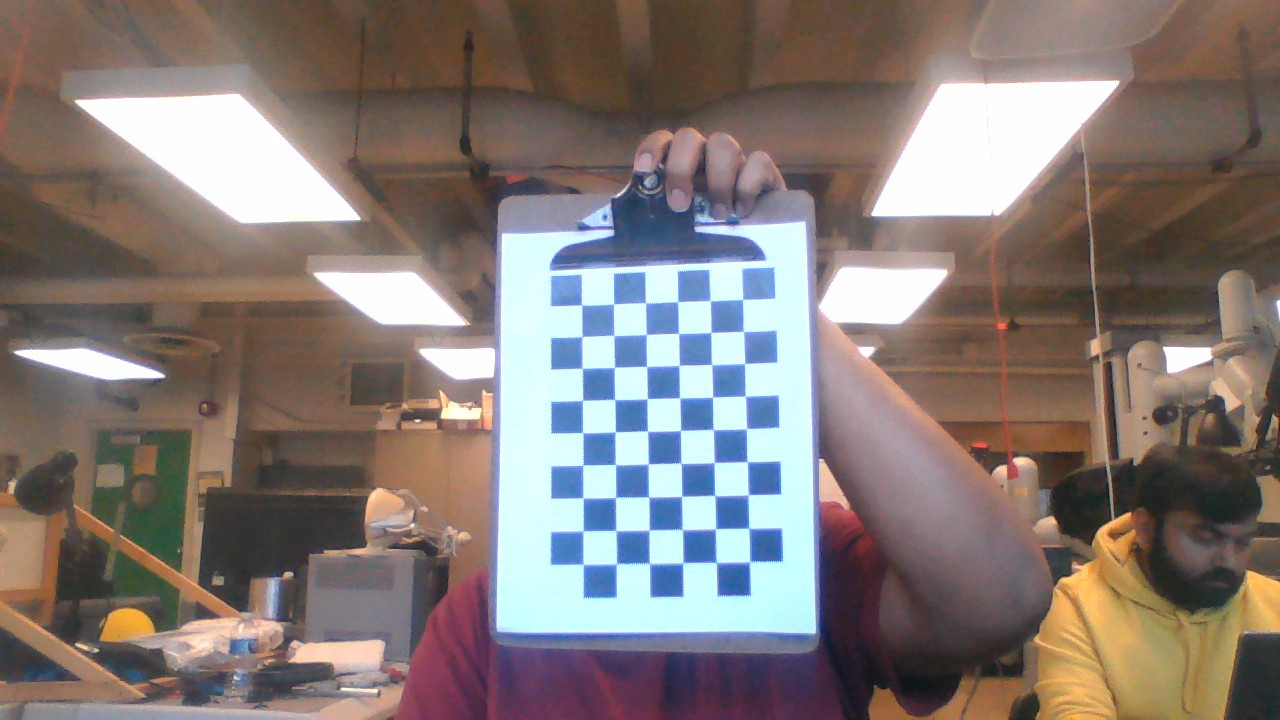
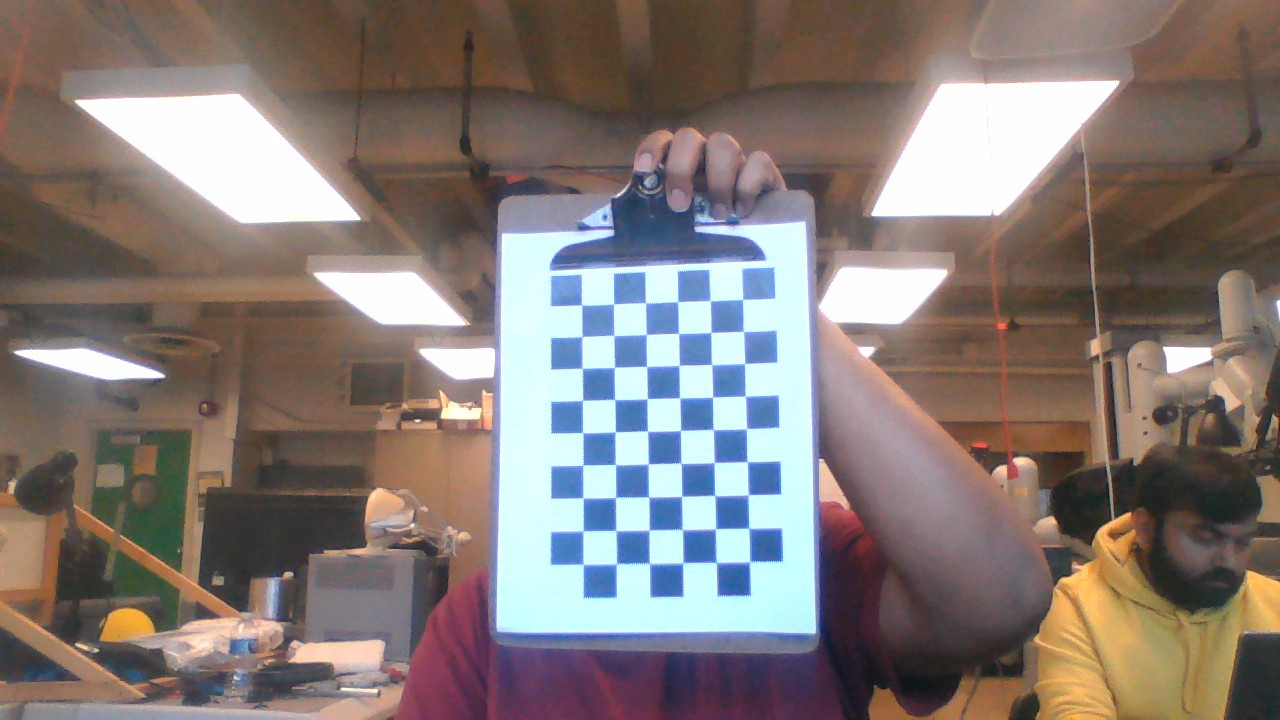
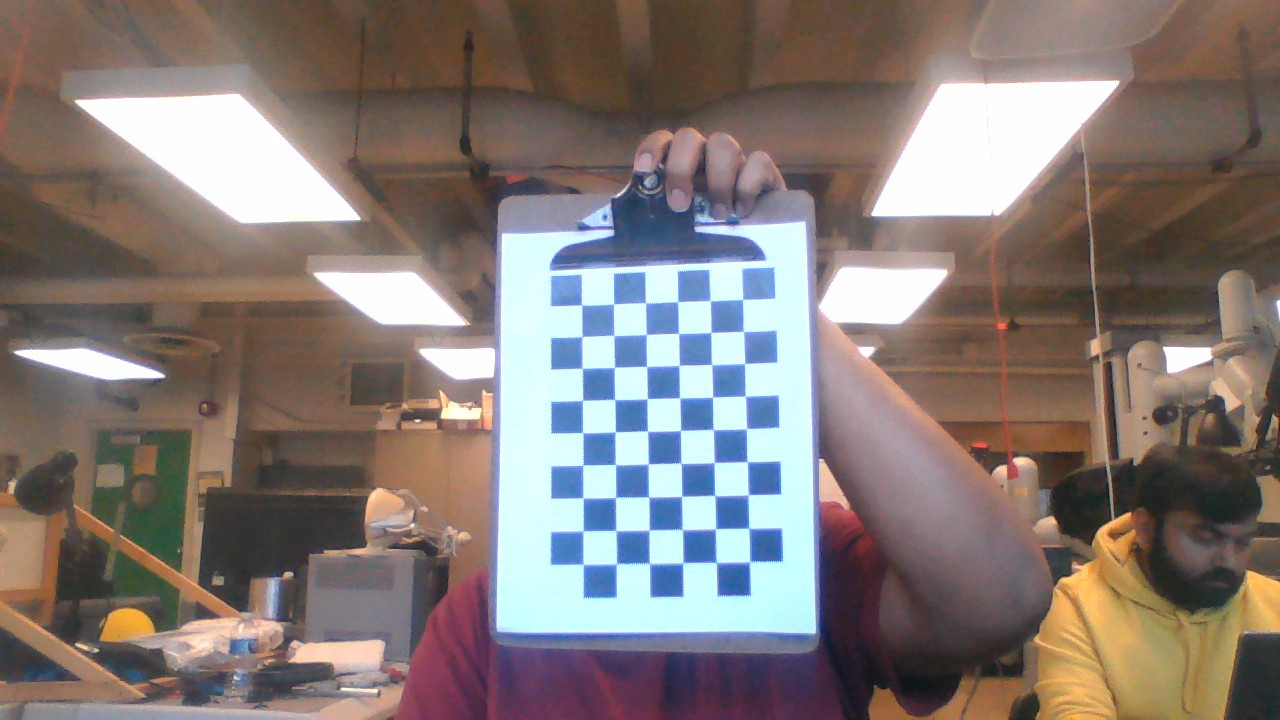
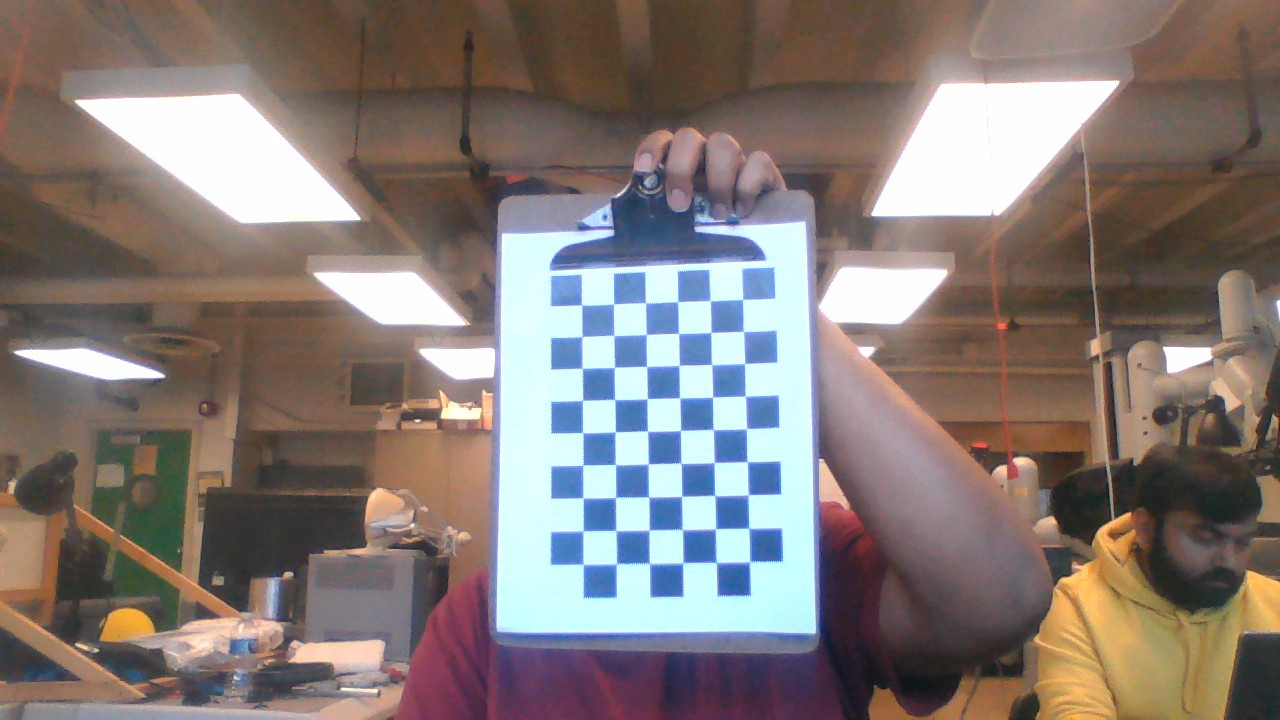
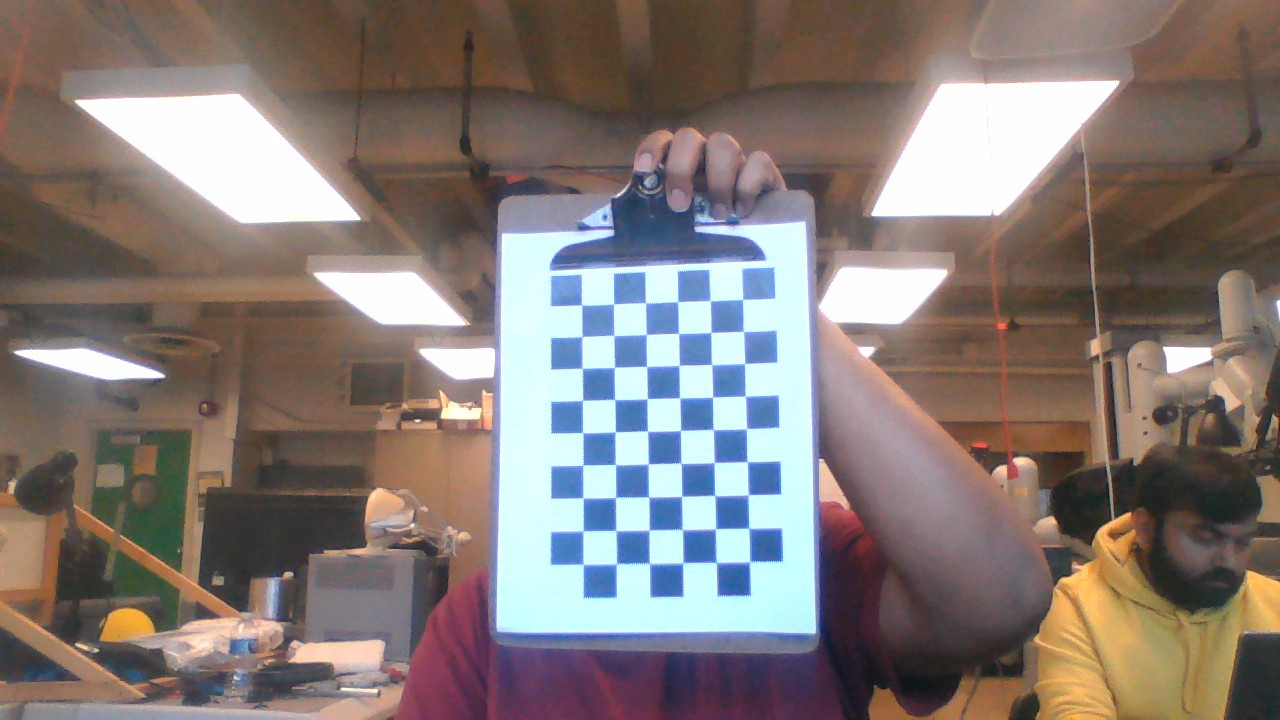


BELOW ARE THE PROCESSED IMAGES DURING CAMERA CALIBRATION

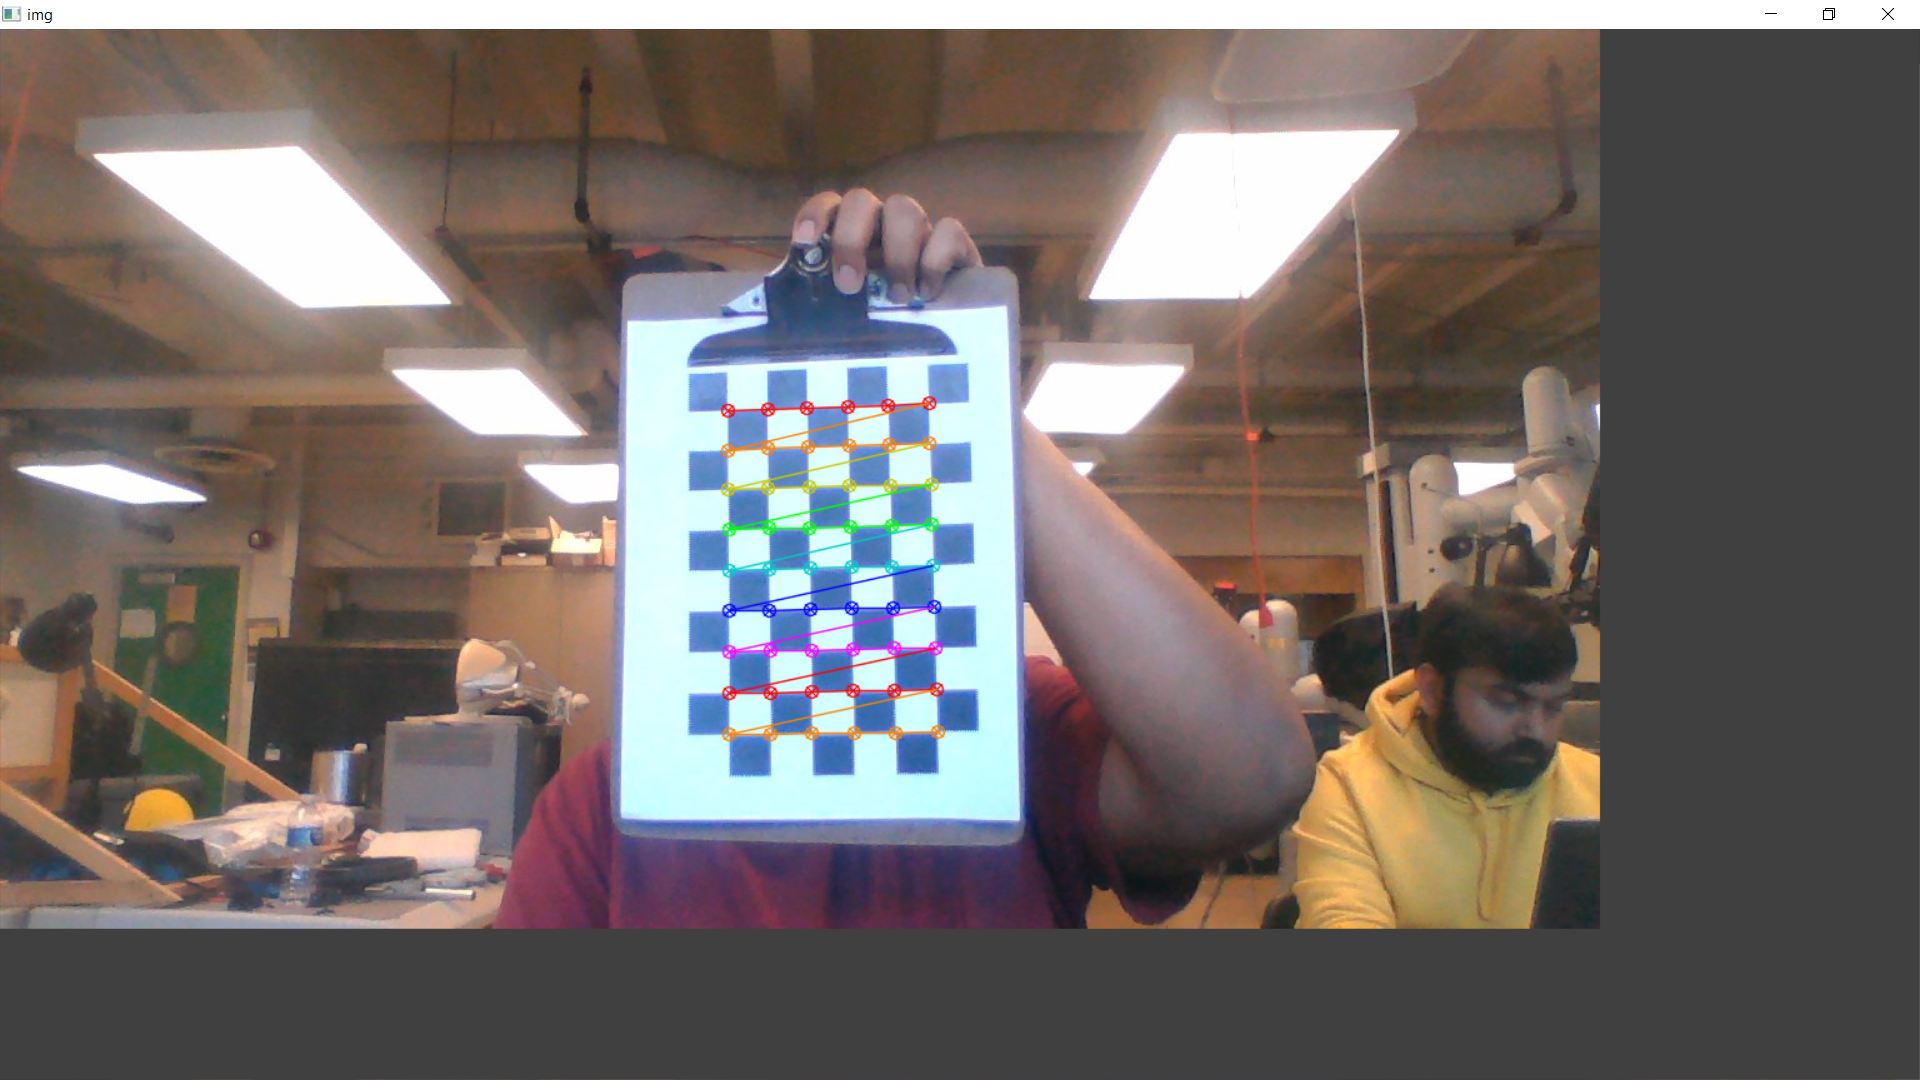
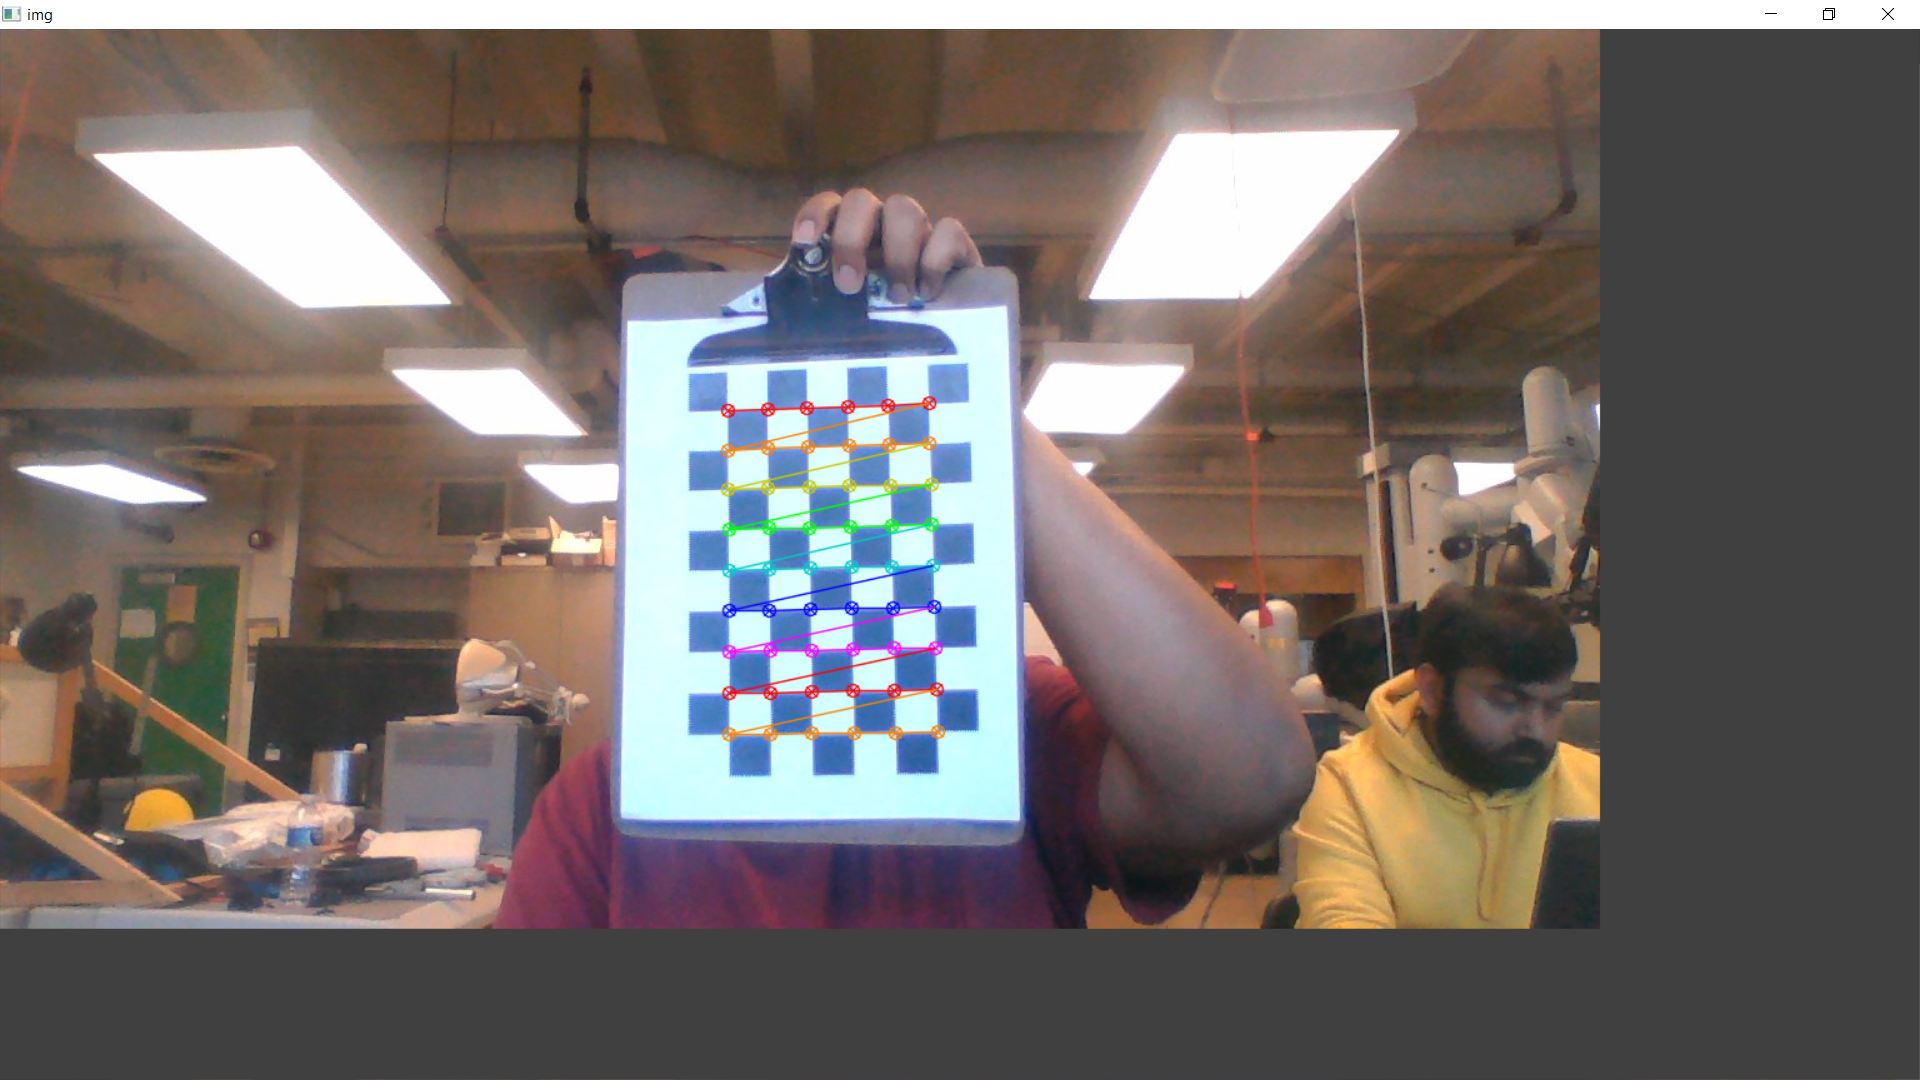
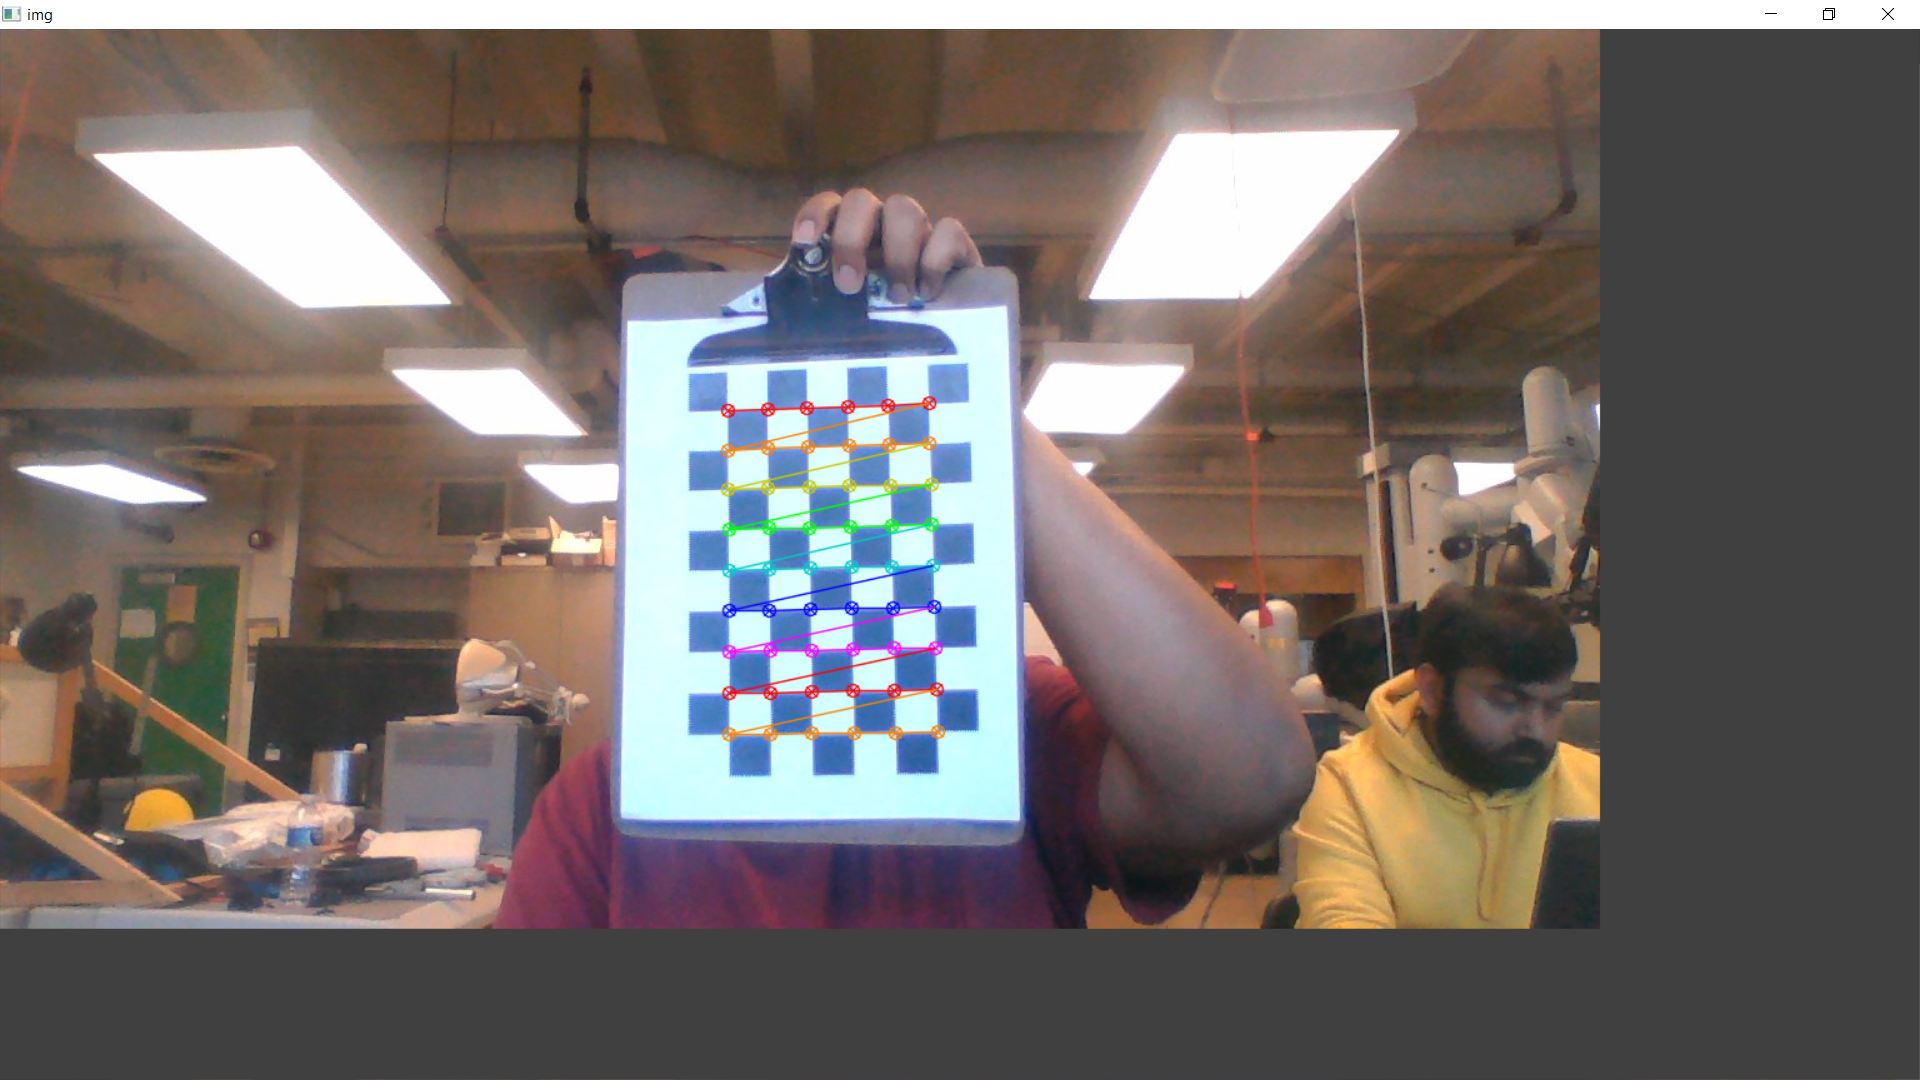
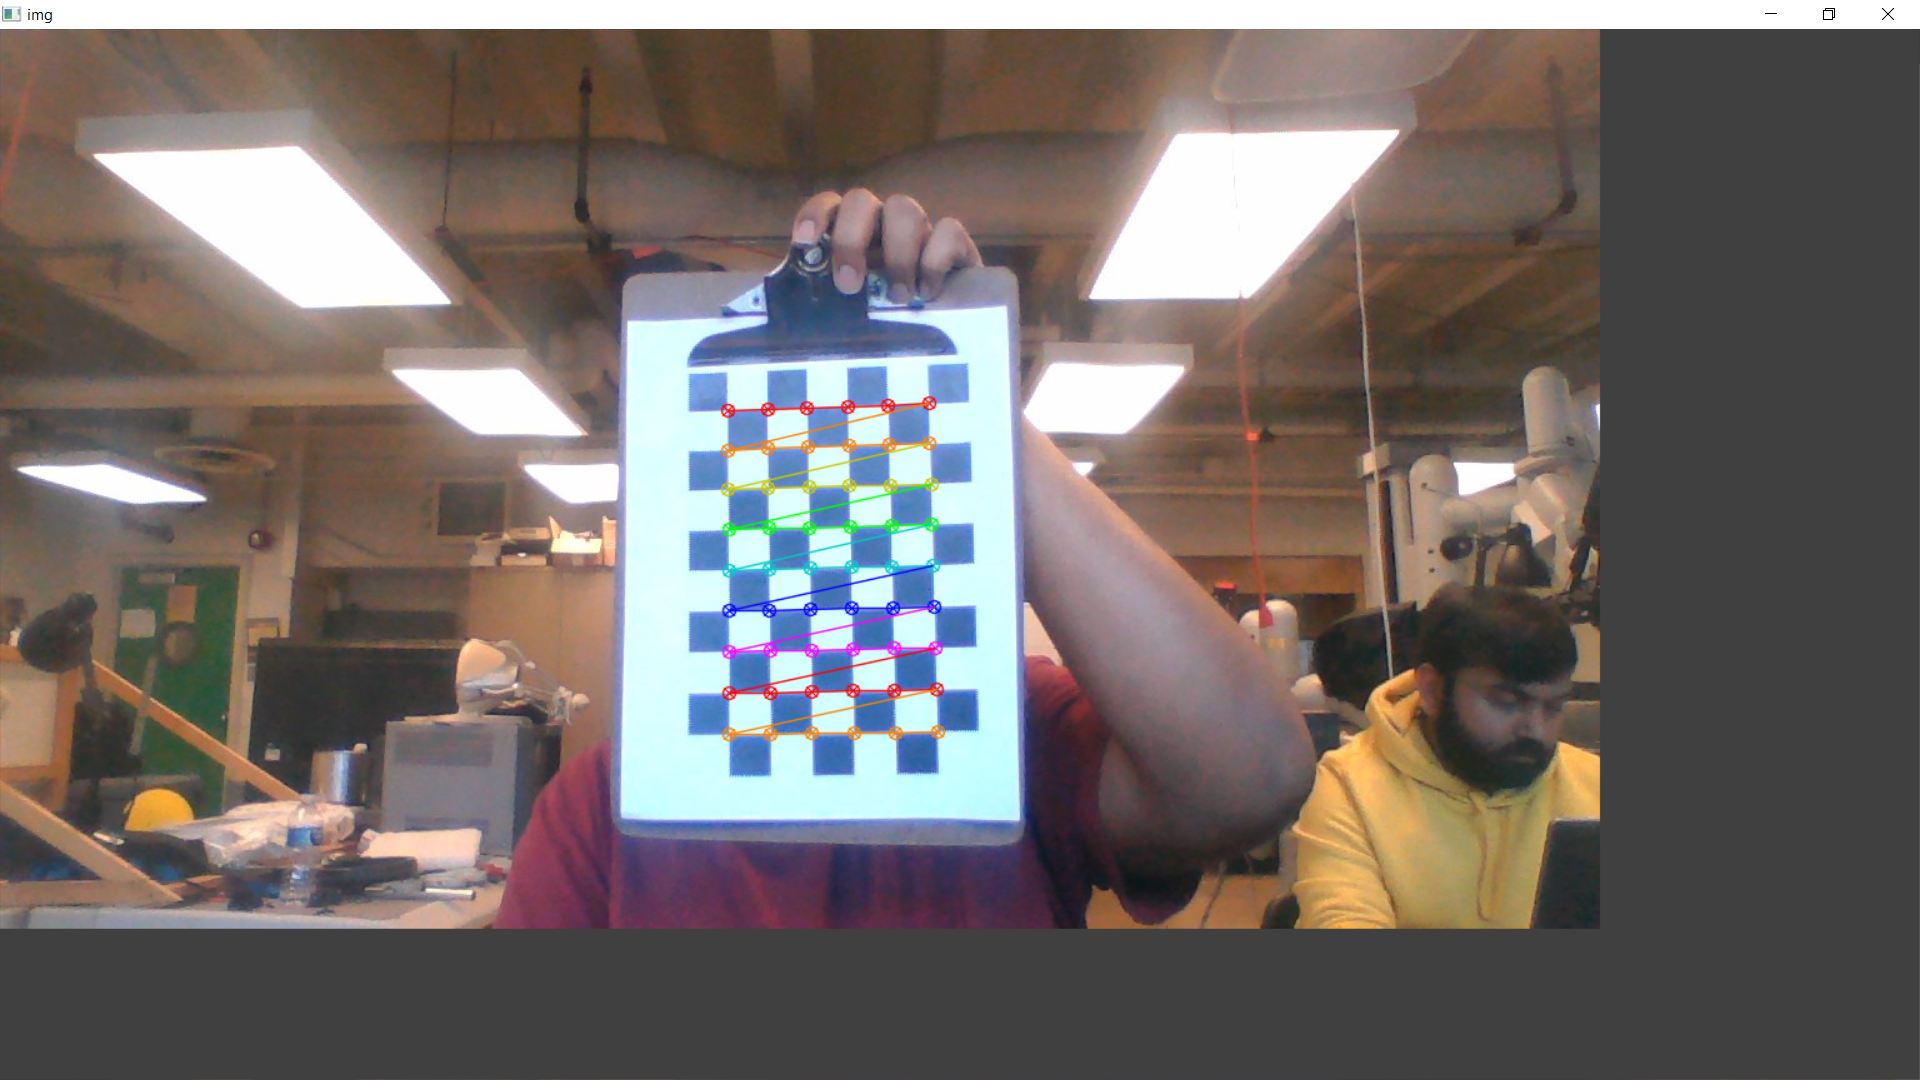
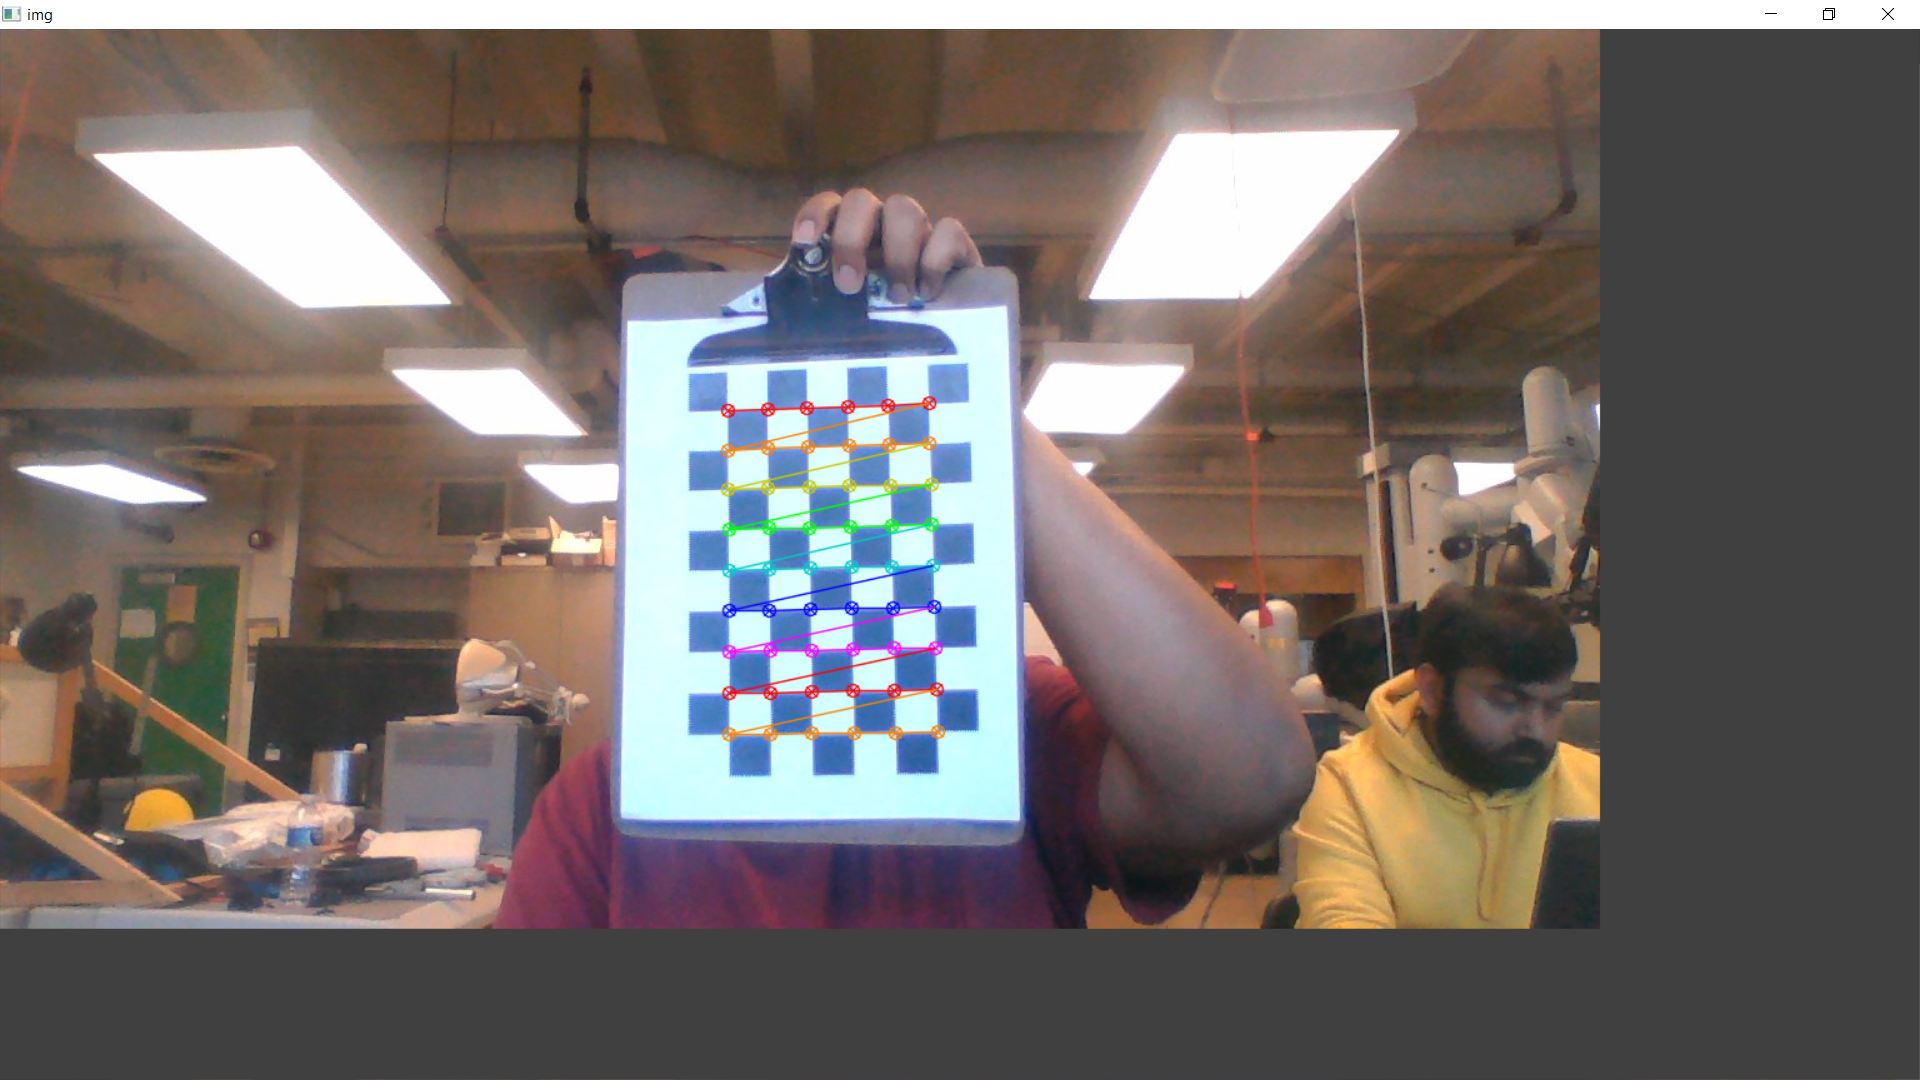

BELOW IS THE APRIL TAG WE USED

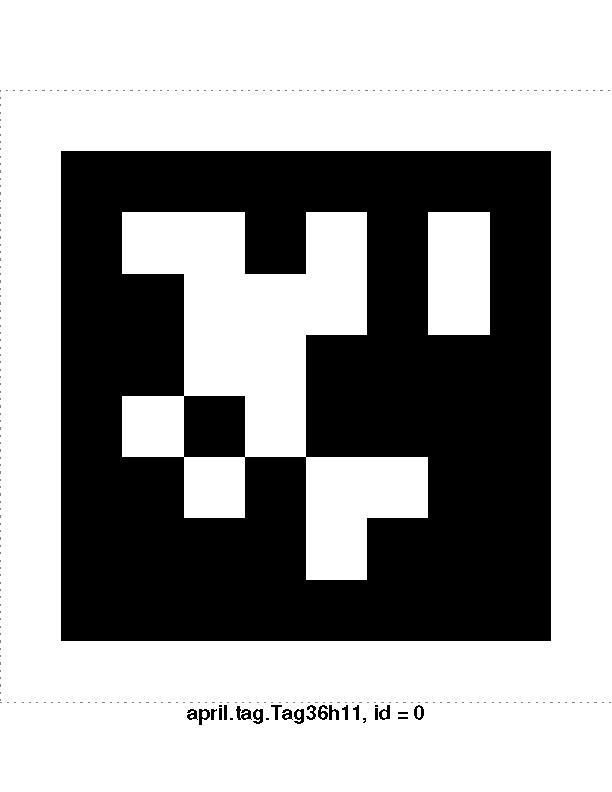